# Project 2

TEAM-ID: 16 <br>
TEAM-NAME: spacex  <br>
YOUR-ID: 2019121004 , 2018102002  <br>
YOUR-NAME: Avani Gupta, Sreeharsha Paruchuri  <br> 

## Topic : Stereo reconstruction and Non-linear optimization

#### Instructions
<ul>
    <li> The second project of the course is designed to get you familiar with stereo reconstruction, and non-linear optimization </li>
    <li> Use python for this project. PILLOW and OpenCV are permitted for image I/O. </li>
    <li> Submit this notebook as a zipped file on moodle. The format should be $<$team_id$>$_$<$team_ name$>$.zip. Both members have to submit this zip file. </li>
    <li> A seperate report is not needed if you're coding in the notebook itself. Please provide adequate descriptions of the approaches you've taken. Also mention work distribution for the two members. </li>
    <li> Refer to the late day policy. Start early </li> 
    <li> Download data from here: https://iiitaphyd-my.sharepoint.com/:f:/g/personal/aryan_sakaria_students_iiit_ac_in/Er5C7351IAlFsvwHUesFeSQBQtlSiAS7AORSEJT2qH_8_w?e=ol98k9  </li>
</ul>


**Note: place the data downloaded from above in data folder in main directory in order to run below cells**

----
### PART 1: Stereo dense reconstruction

3-D point clouds are very useful in robotics for several tasks such as object detection, motion estimation (3D-3D matching or 3D-2D matching), SLAM, and other forms of scene understanding.  Stereo camerasprovide  us  with  a  convenient  way  to  generate  dense  point  clouds.Densehere,  in  contrast  tosparse,means all the image points are used for the reconstruction.  In this part of the assignment you will begenerating a dense 3D point cloud reconstruction of a scene from stereo images.

#### Procedure: 

<ol>
    <li> Generate a disparity map for each stereo pair.  Use OpenCV (e.g.  StereoSGBM) for this.  Notethat the images provided are already rectified and undistorted. </li>
    <li> Then, using the camera parameters and baseline information generate colored point clouds fromeach disparity map.  Some points will have invalid disparity values, so ignore them.  Use [Open3D]for storing your point clouds. </li>
    <li> Register (or transform) all the generated point clouds into your world frame by using the providedground truth poses. </li>
    <li> Visualize the registered point cloud data, in color.  Use Open3D for this </li>
</ol>
    

In [1]:
#import libraries:
import numpy as np 
# from sklearn.preprocessing import normalize #normalizing gives better results. Experiment with this
import cv2
import open3d as o3d
import matplotlib.pyplot as plt

In [2]:
def read_transformations(filename):
    f = open(filename, 'r')
    data = np.loadtxt(filename)
    transformation_list = data.reshape(len(data),3,4);
    return transformation_list

In [3]:
pcd = o3d.geometry.PointCloud()
pcd_final = o3d.geometry.PointCloud()

calib_mat = np.array([[7.070912e+02, 0.000000e+00, 6.018873e+02],
             [0.000000e+00, 7.070912e+02, 1.831104e+02],
             [0.000000e+00, 0.000000e+00, 1.000000e+00]])

f = calib_mat[0,0]
T = read_transformations('data/poses.txt')
nums = 21
b = 0.53790448812

def convert_img_world(disp_map,Q_mat):
    points = []
    for i in range(len(disp_map)):
        points.append(np.matmul(Q_mat,disp_map[i]))
    return np.array(points)


def get_parallax(disp):
    disp_map = []
    for i in range(disp.shape[0]):
        disp_2 = disp[i]
        for j in range(disp.shape[1]):
            disp_map.append([j,i,disp_2[j],1])
    return np.array(disp_map)


def get_disp(img_l,img_r):
    win_size = 5
    stereo = cv2.StereoSGBM_create(minDisparity = -39,
        numDisparities = 144,
        disp12MaxDiff = 1,
        blockSize=5,
        speckleRange = 32,
        uniquenessRatio = 10,
        speckleWindowSize = 100,
        P1= 8*3* win_size**2,
        P2= 32*3*win_size**2,
        preFilterCap= 63
        )
    num_disp = 144
    min_disp = -39
    
    disp = stereo.compute(img_l, img_r).astype(np.float32)/64.0
    disp = disp-min_disp
    disp = disp/num_disp
    return disp

def getQ_mat(disp,f,w):
    Q_mat = np.array([[ 1,  0,  0, -disp.shape[1]/2],
                  [ 0,  -1,  0, disp.shape[0]/2],
                  [ 0,  0,  0, f],
                  [ 0,  0,  1/b, 0]])
    return Q_mat
    
for i in range(nums):    

    img_l = cv2.imread("data/img2/00000004"+str(60+i)+".png")
    img_r = cv2.imread("data/img3/00000004"+str(60+i)+".png")
    
    disp = get_disp(img_l,img_r)
    
    Q_mat = getQ_mat(disp,f,disp[1])
    disp_map = get_parallax(disp)
    
    points_arr = convert_img_world(disp_map,Q_mat)
    
    colors = cv2.cvtColor(img_l, cv2.COLOR_BGR2RGB)
    colors_ar = np.array(colors[(disp >= disp.min())]/255)
   
    for k in range(4):
        points_arr[:,k] = points_arr[:,k]/points_arr[:,3]

    points_arr = np.matmul(T[i],points_arr.T).T
    thresh = 1500
    mask =((-thresh <= points_arr[:,0]) & (points_arr[:,0] < thresh)&
            (-thresh <= points_arr[:,1]) & (points_arr[:,1] < thresh) &
            (-thresh <= points_arr[:,2]) & (points_arr[:,2] < thresh))
            

    points_arr = points_arr[mask]
    points_arr[:,0] *= -1


    pcd.points = o3d.utility.Vector3dVector(points_arr)
    pcd.colors = o3d.utility.Vector3dVector(colors_ar[mask])
    pcd_final = pcd_final + pcd
    print(60+i)

#Saving the combined pcd 
o3d.io.write_point_cloud("Output.pcd", pcd_final)

output = o3d.io.read_point_cloud("Output.pcd")
o3d.visualization.draw_geometries([output])

60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80


## Explanation
Stereo vision systems can be used to generate real time disparity maps and extract 3D information from scenes without the use of super expensive and ugly sensors like LiDAR's. All that's needed is an image pair with sufficient qualilty. A drawback of using this method to obtain 3D world points of a scene is that there should be sufficient lighting. If the 3D world points are obtained, point clouds for the scene can be manufactured and visualised with the help of software such as open3D.

Our KITTI data is "perfect" for this task as it contains rectified stereo images and the readings from the IMU are taken to be very accurate.

Initially, we use a semi global block matching algorithm to find correspondances in the two images. This algorithm works by performing a line optimisation (along the epipolar line) in multiple directions and computing an averge cost function between the intensities of each greyscale image but is highly memory inefficient. Doing this results in a disparity map which is fed to the next part of the code. There are multiple hyperparameters that need tuning in the stereoSGBM matcher which are need to be tuned. Each dataset has unique hyperparameters. The hyper parameters are tuned such that they produce a beautiful disparity for our stereo pair. These parameters dictate the feature matching done along the epipolar line.

In order to reproject the image points into the 3D space, we need something called a baseline matrix. This turns points 180 degrees around the x-axis such that the y-axis looks up. 

We are able to reproject images back to 3d by post multiplying the Q matrix with $\begin{bmatrix}x & y  &disp[x][y] & 1\end{bmatrix}^{T}$. This gives us 3D points in the coordinate frame used by opencv. This alone is enough to generate the individual dense point-clouds for each stereo-pair.

We now have the points. We extract the colours from the image and bring the colourspace from BGR (which is how opencv reads images) back to RGB.

With the 3D points and their corresponding colours, we can generate a point cloud for a given stereo pair.

What we aim to do in this project is to register all the point clouds according to the given odometry data obtained from the KITTI IMU. To do this, we must take care that the points of the point cloud are in the same frame as the IMU. Then using matrix multiplication, we get out points into the world frame. A sanity check can be done here to check if the registration is happening properly or not. Instead of passing the points from the image, one could pass a sparse NumPy array which has a small block of ones and every other entry to be zero. This array can then be registered using the given odometry. If a curve appears in the final output then the registration is happening properly.

----
### PART 2: Motion estimation using iterative PnP

Using the generated reconstruction from the previous part, synthesize a new image taken by a virtualmonocular camera fixed at any arbitrary position and orientation.  Your task in this part is to recoverthis pose using an iterative Perspective-from-n-Points (PnP) algorithm. 

#### Procedure: 

<ol>
    <li> Obtain a set of 2D-3D correspondences between the the image and the point cloud.  Since hereyou’re generating the image, this should be easy to obtain. </li>
    <li> For this set of correspondences compute the total reprojection error c= $\sum_{i} ‖x_i−P_{k}X_i‖^2 $    where $P_{k}= K[R_{k}|t_{k}]$, $X_{i}$ is the 3D point in the world frame, $x_{i}$ is its corresponding projection. </li>
    <li> Solve for the pose $T_{k}$ that minimizes this non-linear reprojection error using a Gauss-Newton (GN)scheme.  Recall that in GN we start with some initial estimated value $x_{o}$ and iteratively refine the estimate using $x_{1}$= $∆x+x_0$, where $∆x$ is obtained by solving the normal equations $J^{T}J∆x$= -$J^{T}e$, until convergence.The main steps in this scheme are computing the corresponding Jacobians and updating the estimates correctly.  For our problem,  use a 12×1 vector parameterization for $T_{k}$(the top 3×4submatrix).  Run the optimization for different choices of initialization and report your observations. </li>
</ol>

Poses Ground truth 
 [[-8.90929517e+02  5.38387637e+01 -2.56109933e+02 -1.53083396e+05]
 [-3.68165080e+01  7.13415332e+02 -1.52284250e+02  2.00006057e+01]
 [-4.11338164e-01  4.10740947e-02 -9.10556891e-01 -2.77880277e+01]]


Transforms ground truth 
 [[-9.09854768e-01  4.11782636e-02  4.12878417e-01 -1.92843773e+02]
 [ 5.44537786e-02  9.98307203e-01  2.04332712e-02  7.22435448e+00]
 [-4.11338164e-01  4.10740947e-02 -9.10556891e-01 -2.77880277e+01]]


Initialised P from DLP
 [[ 3.20616341e+01 -1.93747852e+00  9.21655800e+00  5.50896991e+03]
 [ 1.32490589e+00 -2.56734829e+01  5.48021064e+00 -7.19790961e-01]
 [ 1.48027138e-02 -1.47812755e-03  3.27679579e-02  1.00000000e+00]]

Initial cost 
 712.6278083526804


Gauss Newton converged at iteration  13
cost  1.187623822830479





P_Optimized 
 [[-8.90928661e+02  5.38386754e+01 -2.56107723e+02 -1.53083119e+05]
 [-3.68143895e+01  7.13415119e+02 -1.52279176e+02  2.04081935e+01]
 [-4.11338163e-01  4.10740946e-02 -9.10556890e-01 -2.77880277e+01]

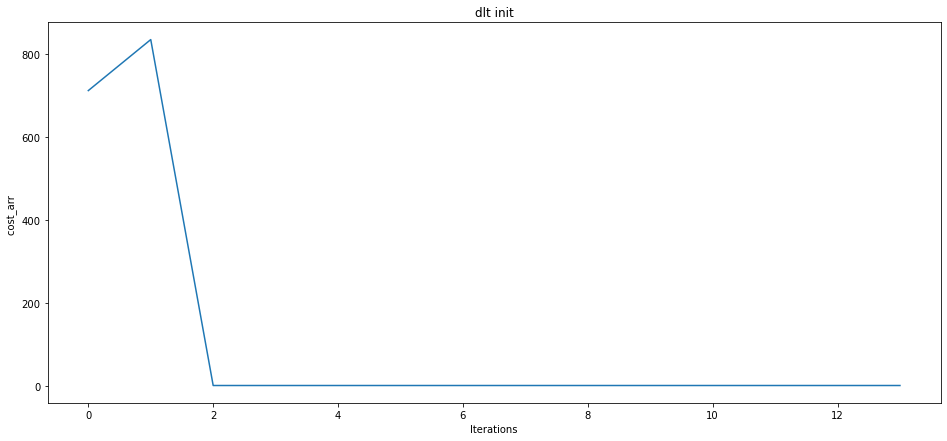

In [6]:
def read_pcd(file_name):
    pcd = o3d.io.read_point_cloud(file_name) 
    pcd_points = np.hstack((np.asarray(pcd.points),np.ones((len(pcd.points),1))))
    return pcd_points


def find_Transfroms_gt(T):
    Transfroms_gt = np.append(T[0],[0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]).reshape(4,4)
    Transfroms_gt = np.linalg.inv(Transfroms_gt)
    return Transfroms_gt


def perform_DLT(x,X):
    a = x[0]
    x = x[:10,:]
    a_X = X[0]
    X = X[:10,:]
    
    for i in range(2):
        x[:,i] = x[:,i]/x[:,2]
  
    a1 = x[:,0]*X[:,2]
    a2 = x[:,0]*X[:,3]
    u = np.vstack((a1,a2))
    v = np.vstack((x[:,0]*X[:,1],u))
    w = np.vstack((x[:,0]*X[:,0],v)).T
   
    a1 = x[:,1]*X[:,2]
    a2 = x[:,1]*X[:,3]
    u_ = np.vstack((a1,a2))
    v_ = np.vstack((x[:,1]*X[:,1],u_))
    w_ = np.vstack((x[:,1]*X[:,0],v_)).T
    
    zeros = np.zeros((len(X),4))
    X = -X
    a = np.hstack((zeros,w))
    a_ = np.hstack((X,w_))
    b = np.hstack((zeros,a_))   
    
    mat = np.vstack((np.hstack((X,a)),b))
    
    U,D,VT = np.linalg.svd(mat)
    
    P = np.array(VT[-1])
    P = P.reshape(3,4)
    
    return P/P[-1,-1]


def get_Jacobian(x,X):
    for i in range(4):
        X[:,i] = X[:,i]/x[:,2]
        
    for i in range(2):
        x[:,i] = x[:,i]/x[:,2]
  
    zeros = np.zeros((len(X),4))
    a1 = x[:,0]*X[:,2]
    a2 = x[:,0]*X[:,3]
    u = np.vstack((a1,a2))
    v = np.vstack((x[:,0]*X[:,1],u))
    w = np.vstack((x[:,0]*X[:,0],v)).T
   
    a1 = x[:,1]*X[:,2]
    a2 = x[:,1]*X[:,3]
    u_ = np.vstack((a1,a2))
    v_ = np.vstack((x[:,1]*X[:,1],u_))
    w_ = np.vstack((x[:,1]*X[:,0],v_)).T

    Jaco = np.vstack((np.hstack((-X,np.hstack((zeros,w)))),np.hstack((zeros,np.hstack((-X,w_))))))
    return Jaco

def get_residual(x,x_ground_truth):
    den = x_ground_truth[:,2]
    res_2= x_ground_truth[:,1]/den
    res_2 -= x[:,1]/x[:,2]
    res_1 = x_ground_truth[:,0]/den
    res_1 -= x[:,0]/x[:,2]
    residual = np.hstack((res_1,res_2))
    residual = residual.reshape(-1,1)
    return residual


def perform_Gauss_newton(P,x_ground_truth,X,nums,tolerance):
    residual = np.zeros(X.shape)
    cost_arr = np.zeros(nums)
    converged = 0
    for i in range(nums):
        x = np.matmul(P,X.T).T
        residual = get_residual(x,x_ground_truth) 
        cost_arr[i] = (np.matmul(residual.T,residual)/2/len(X)).item(0)
        J = get_Jacobian(x,X)
        H = np.matmul(J.T,J)
        delta = np.linalg.inv(H)@J.T@residual
        P = (P.reshape(12,1) - delta).reshape(3,4)    
        if(i==0):
            print("\nInitial cost \n",cost_arr[0])
        norm = np.linalg.norm(delta)   
        if(norm<tolerance):
            converged = 1
            print("\n")
            print("Gauss Newton converged at iteration ",i)
            print("cost ",cost_arr[i])
            print("\n\n")
            break 
    if(converged==0):
        print('Didnot converge in ',nums,' iters')
        print('cost ',cost_arr[i])
    return P, cost_arr, i

X_ground_truth = read_pcd("Output.pcd")[0::10,:]
Transfroms_gt = find_Transfroms_gt(T)
P_ground_truth = np.matmul(calib_mat,Transfroms_gt[:3,:4])
x_ground_truth = np.matmul(P_ground_truth,X_ground_truth.T).T

P_init = perform_DLT(x_ground_truth,X_ground_truth)
print("Poses Ground truth \n",P_ground_truth)
k_inv = np.linalg.inv(calib_mat)
Transfroms_gt = np.matmul(k_inv,P_ground_truth)
print('\n')
print("Transforms ground truth \n",Transfroms_gt)
print('\n')
print("Initialised P from DLP\n",P_init)


P_optimized, cost_arr, it_conv = perform_Gauss_newton(P_init,x_ground_truth,X_ground_truth,1000,1e-7)
P_optimized = P_ground_truth[-1,-1]*P_optimized/P_optimized[-1,-1] 

print('\n')
print("P_Optimized \n",P_optimized)

k_inv = np.linalg.inv(calib_mat)
T_op = np.matmul(k_inv,P_optimized)
print('\n')
print("T_Output \n",T_op)

def plot(it_conv,cost_arr,title_str):
    plt.figure(figsize=(16,7))
    y = cost_arr[0:it_conv+1]
    x = range(it_conv+1)
    plt.plot(x, y)
    plt.title(title_str)
    plt.xlabel('Iterations')
    plt.ylabel('cost_arr ')
    


plot(it_conv,cost_arr,'dlt init')

#### try different inits

Poses Ground truth 
 [[-8.90929517e+02  5.38387637e+01 -2.56109933e+02 -1.53083396e+05]
 [-3.68165080e+01  7.13415332e+02 -1.52284250e+02  2.00006057e+01]
 [-4.11338164e-01  4.10740947e-02 -9.10556891e-01 -2.77880277e+01]]


Transforms ground truth 
 [[-9.09854768e-01  4.11782636e-02  4.12878417e-01 -1.92843773e+02]
 [ 5.44537786e-02  9.98307203e-01  2.04332712e-02  7.22435448e+00]
 [-4.11338164e-01  4.10740947e-02 -9.10556891e-01 -2.77880277e+01]]

 
 **noise added** 1e-06


Initialised P 
 [[-8.90929515e+02  5.38387621e+01 -2.56109935e+02 -1.53083396e+05]
 [-3.68165069e+01  7.13415333e+02 -1.52284250e+02  2.00006057e+01]
 [-4.11337730e-01  4.10732314e-02 -9.10557384e-01 -2.77880270e+01]]

Initial cost 
 1110858.812866331


Gauss Newton converged at iteration  4
cost  1.0077317161850958e-09





P_Optimized 
 [[-8.90929517e+02  5.38387638e+01 -2.56109933e+02 -1.53083396e+05]
 [-3.68165081e+01  7.13415332e+02 -1.52284250e+02  2.00006205e+01]
 [-4.11338164e-01  4.10740947e-02 -9.1055689

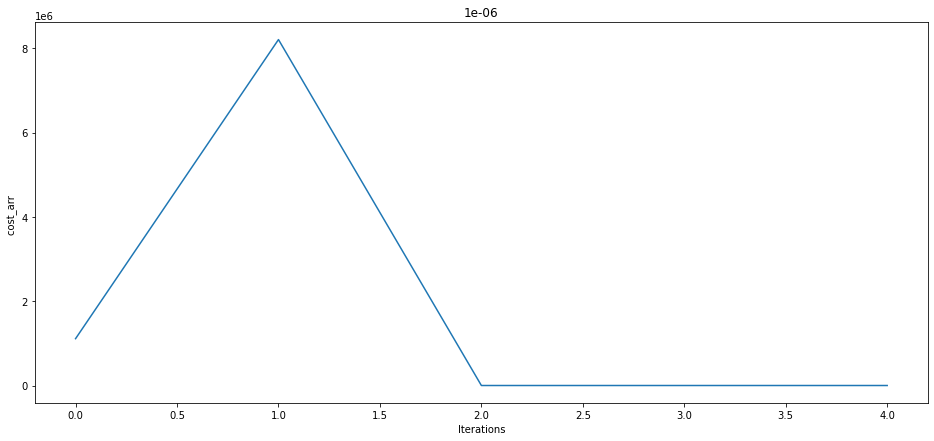

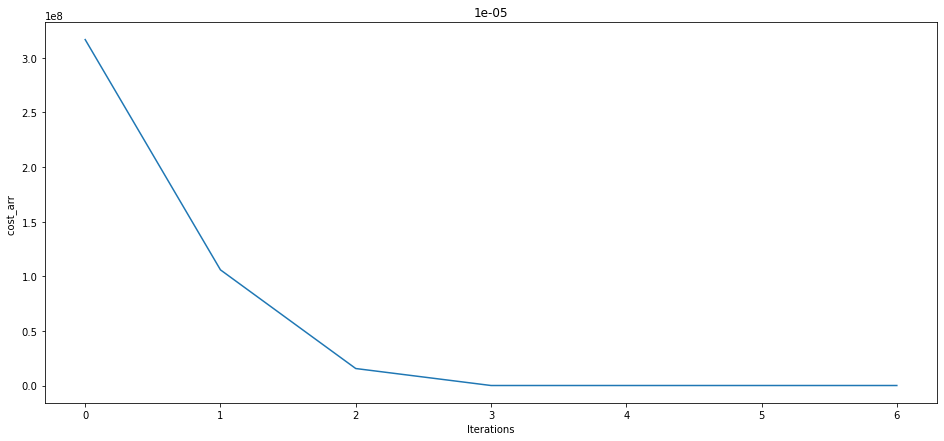

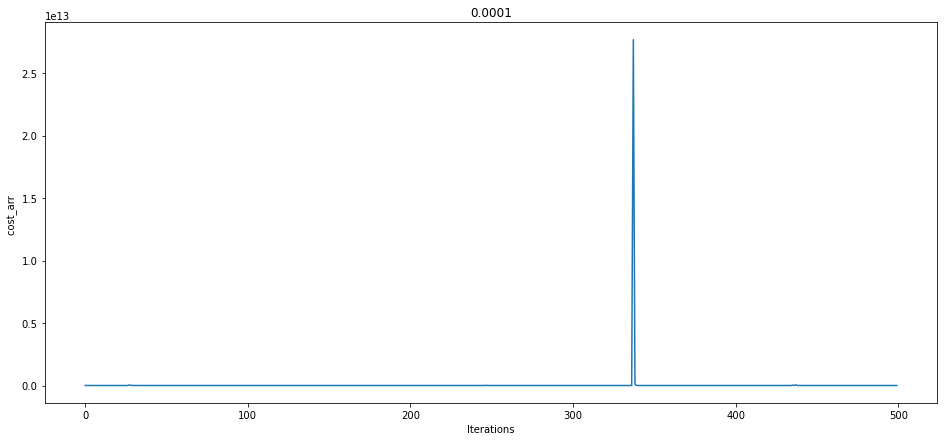

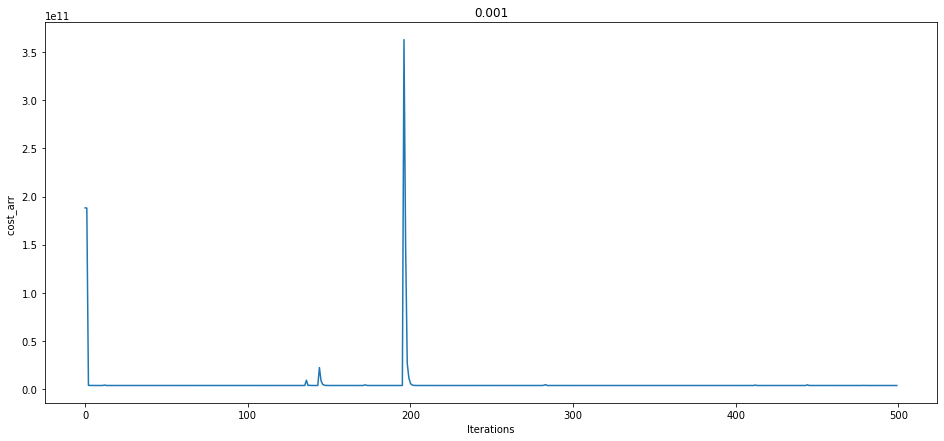

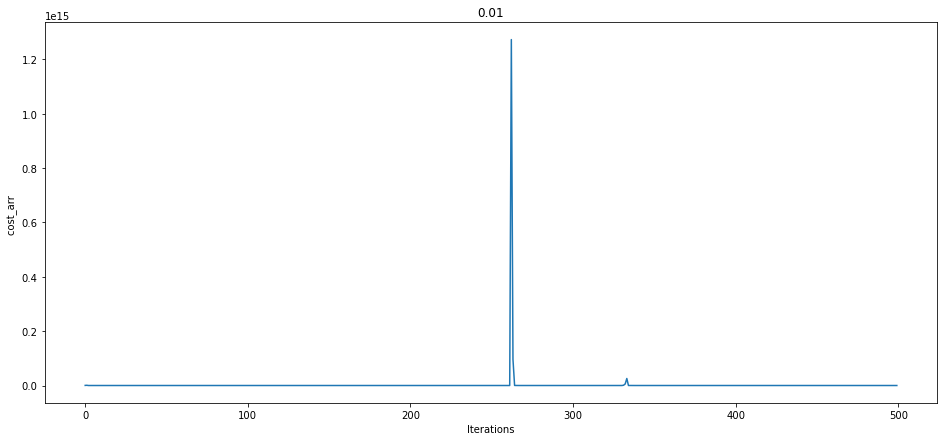

In [7]:
X_ground_truth = read_pcd("Output.pcd")[0::10,:]
Transfroms_gt = find_Transfroms_gt(T)
P_ground_truth = np.matmul(calib_mat,Transfroms_gt[:3,:4])
x_ground_truth = np.matmul(P_ground_truth,X_ground_truth.T).T
print("Poses Ground truth \n",P_ground_truth)
k_inv = np.linalg.inv(calib_mat)
Transfroms_gt = np.matmul(k_inv,P_ground_truth)
print('\n')
print("Transforms ground truth \n",Transfroms_gt)
#Adding noise to ground truth mat to try a different initialization of P
noise_vals = [.000001, 0.00001, 0.0001,0.001, 0.01]
for i in range(len(noise_vals)):
    
    print('\n \n **noise added**',noise_vals[i])
    noise_mat = np.random.normal(0, noise_vals[i], P_ground_truth.shape)
    P_init = P_ground_truth + noise_mat 
    print('\n')
    print("Initialised P \n",P_init)
    P_optimized, cost_arr, it_conv = perform_Gauss_newton(P_init,x_ground_truth,X_ground_truth,500,1e-2)
    P_optimized = P_ground_truth[-1,-1]*P_optimized/P_optimized[-1,-1] 
    print('\n')
    print("P_Optimized \n",P_optimized)
    k_inv = np.linalg.inv(calib_mat)
    T_op = np.matmul(k_inv,P_optimized)
    print('\n')
    print("T_Output ",T_op)
    
    plot(it_conv,cost_arr,str(noise_vals[i]))
    print('--------------------------------------------------------------------')

The results for different initializations by adding noise to ground truth 

|initialization noise|initial cost|No. of iterations|final cost|
:-------------------------:|:-------------------------:|:----------------:|:---:|
1e-06    | 1110858.812866331|4|  1.0077317161850958e-09|
1e-05   |  316701112.7863869|6| 3.4383165390995743e-09|
0.0001    | 4794805913.036788|did'nt converge in 500| 2649067645.9348745|
0.001    |  188191309451.86758|did'nt converge in 500| 3397176513.544524|
0.01    |   379878985780.8991|did'nt converge in 500|3405524833.219916
 |